# 3. Expérimentation et comparaison des architectures RNN

### Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

Sequential = tf.keras.models.Sequential
SimpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Bidirectional = tf.keras.layers.Bidirectional
EarlyStopping = tf.keras.callbacks.EarlyStopping
Adam = tf.keras.optimizers.Adam


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### Paramètres Modifiables

In [2]:
WINDOW_SIZE = 14
UNITS = 64
DROPOUT = 0.2
STACKED = False         # True pour empiler deux couches RNN
USE_BIDIRECTIONAL = False  # True pour utiliser Bidirectional

### Chargement des données prétraitées

In [3]:
def load_dataset(path):
    df = pd.read_csv(path, header=None)
    data = df.values
    X = data[:, :-1]
    y = data[:, -1]
    return X[..., np.newaxis], y

X_train, y_train = load_dataset("../data/TrainDataSet.csv")
X_val, y_val = load_dataset("../data/ValidationDataSet.csv")
X_test, y_test = load_dataset("../data/TestDataSet.csv")

### Construction du modèle

In [4]:
def build_model(rnn_type="SimpleRNN"):
    model = Sequential()
    rnn_layer = None

    # Choix du type de couche RNN
    if rnn_type == "SimpleRNN":
        rnn_layer = SimpleRNN(UNITS, return_sequences=STACKED or USE_BIDIRECTIONAL, input_shape=(WINDOW_SIZE, 1))
    elif rnn_type == "LSTM":
        rnn_layer = LSTM(UNITS, return_sequences=STACKED or USE_BIDIRECTIONAL, input_shape=(WINDOW_SIZE, 1))
    elif rnn_type == "GRU":
        rnn_layer = GRU(UNITS, return_sequences=STACKED or USE_BIDIRECTIONAL, input_shape=(WINDOW_SIZE, 1))

    # Enveloppe Bidirectionnelle si activée
    if USE_BIDIRECTIONAL:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    # Deuxième couche RNN si empilement activé
    if STACKED:
        if rnn_type == "SimpleRNN":
            model.add(SimpleRNN(UNITS))
        elif rnn_type == "LSTM":
            model.add(LSTM(UNITS))
        elif rnn_type == "GRU":
            model.add(GRU(UNITS))

    # Couche de sortie
    model.add(Dropout(DROPOUT))
    model.add(Dense(1))
    return model

### Compilation et Entraînement

In [5]:
def compile_and_train(model, X_train, y_train, X_val, y_val):
    model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Affichage de la courbe d'apprentissage
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Courbe de perte - {model.name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

### Évaluation du modèle

In [6]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Visualisation des prédictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label='Réel')
    plt.plot(y_pred, label='Prédit')
    plt.title(f"Réel vs Prédit - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"Modèle": name, "MSE": mse, "MAE": mae, "RMSE": rmse}

### Boucle principale d'expérimentation


===== Entraînement du modèle : SimpleRNN =====


d:\Masi\Framework\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


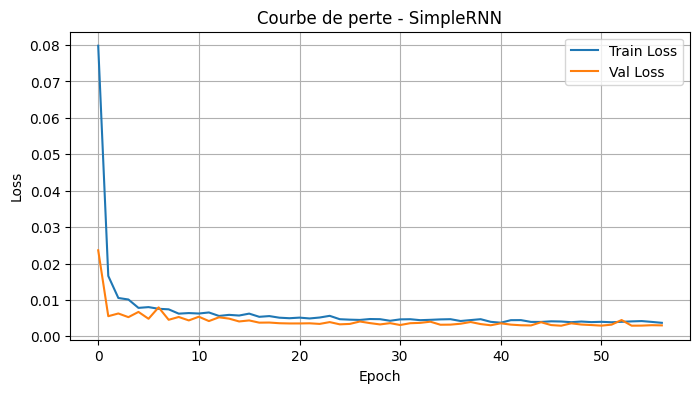

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
SimpleRNN - MSE: 0.0021, MAE: 0.0361, RMSE: 0.0460


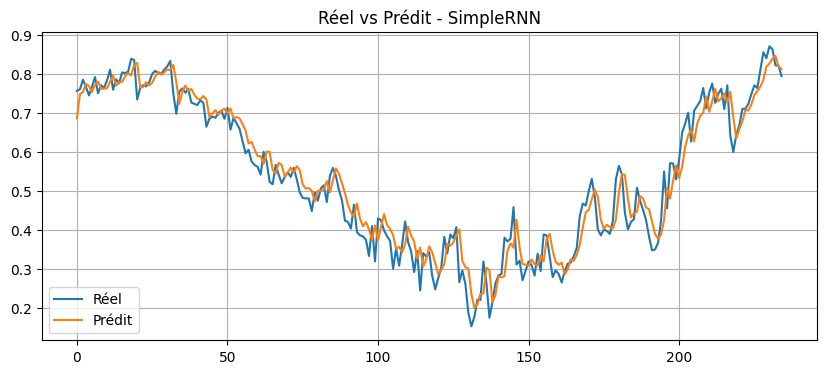


===== Entraînement du modèle : LSTM =====


d:\Masi\Framework\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


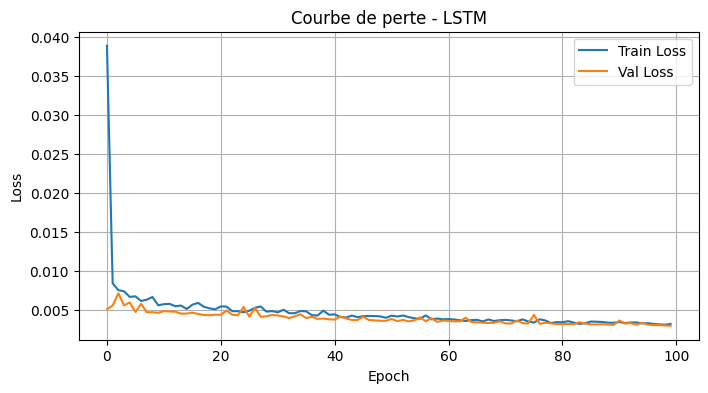

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM - MSE: 0.0021, MAE: 0.0361, RMSE: 0.0459


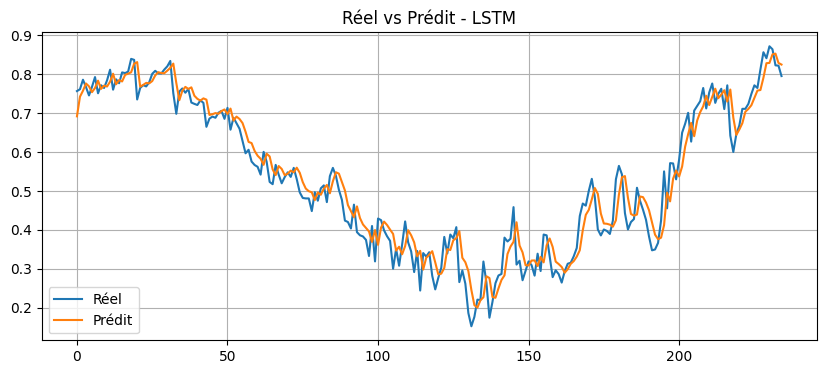


===== Entraînement du modèle : GRU =====


d:\Masi\Framework\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


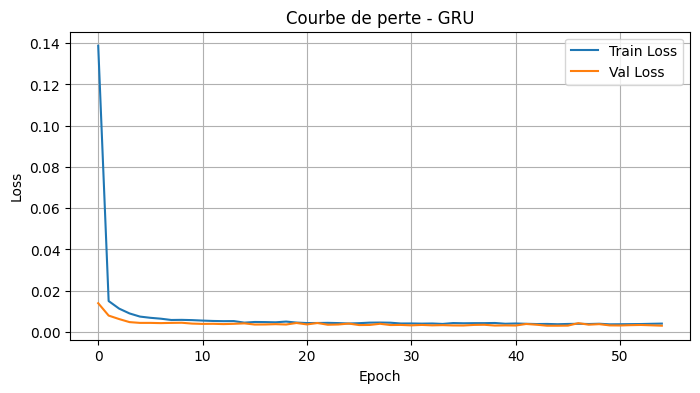

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GRU - MSE: 0.0021, MAE: 0.0362, RMSE: 0.0460


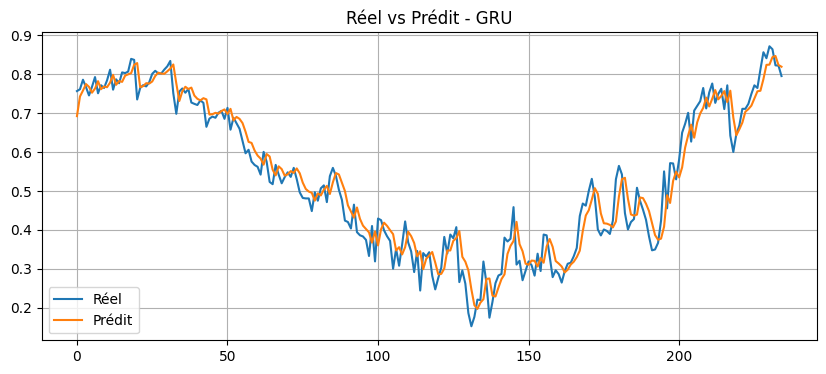

In [7]:
results = []
trained_models = {}  # Dictionnaire pour stocker les modèles

for rnn_type in ["SimpleRNN", "LSTM", "GRU"]:
    print(f"\n===== Entraînement du modèle : {rnn_type} =====") 
    model = build_model(rnn_type)
    model.name = rnn_type
    model = compile_and_train(model, X_train, y_train, X_val, y_val)
    
    # Évaluer et stocker les résultats
    metrics = evaluate_model(model, X_test, y_test, rnn_type)
    results.append(metrics)
    
    # Enregistrer le modèle entraîné
    trained_models[rnn_type] = model


### Tableau comparatif final

In [8]:
results_df = pd.DataFrame(results)
print("\nComparaison des performances :")
print(results_df)


Comparaison des performances :
      Modèle       MSE       MAE      RMSE
0  SimpleRNN  0.002111  0.036124  0.045950
1       LSTM  0.002104  0.036075  0.045867
2        GRU  0.002116  0.036238  0.045999


**Notebook suivant : Entrainement et compilation du modèle**

👉 [Aller au Notebook suivant](04_entrainement_et_compilation.ipynb)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


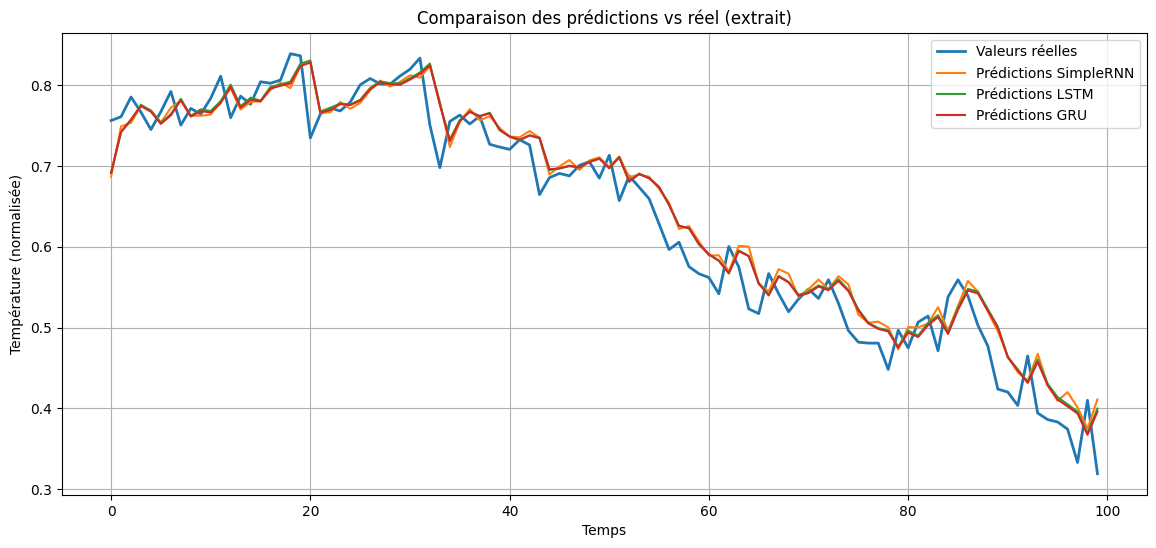

In [9]:
# === Visualisation comparée des prédictions ===
N = 100
plt.figure(figsize=(14, 6))
plt.plot(y_test[:N], label="Valeurs réelles", linewidth=2)

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    plt.plot(y_pred[:N], label=f"Prédictions {name}")

plt.title("Comparaison des prédictions vs réel (extrait)")
plt.xlabel("Temps")
plt.ylabel("Température (normalisée)")
plt.legend()
plt.grid(True)
plt.show()

